In [1]:
#custome modules
import acquire as a
import wrangle as w

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# import standard libraries
import pandas as pd
import re

# import file managers
from os.path import isfile
import pickle

# import json handler
import json

# import language detector
from langdetect import detect

import nltk
import unicodedata
import pandas as pd
import re

#imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natasharivers/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natasharivers/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<hr style="border:2px solid black"> </hr>

# Acquire/Prepare

In [2]:
df= w.wrangle_github_repos(new_pickles=False, get_new_links=False,
                                             number_of_pages=25)

In [3]:
df.head()

,repository,original_readme,cleaned_readme,lemmatized_readme,original_char_length,cleaned_char_length,pct_char_removed,natural_language,programming_language
0,ieee8023/covid-chestxray-dataset,\n#### 🛑 Note: please do not claim diagnostic ...,note please claim diagnostic performance model...,note please claim diagnostic performance model...,10610,4170,39,en,Jupyter Notebook
1,geohot/corona,# Reverse engineering the coronavirus (SARS-Co...,reverse engineering coronavirus sars cov 2 sta...,reverse engineering coronavirus sars cov 2 sta...,13101,3883,29,en,Python
2,ahmadawais/corona-cli,"<h4 align=""center"">\n <a href=""https://gith...",track coronavirus disease covid 19 novel coron...,track coronavirus disease covid 19 novel coron...,15371,4855,31,en,JavaScript
3,ExpDev07/coronavirus-tracker-api,"<h1 align=""center"">\n Coronavirus Tracker A...",coronavirus tracker api provides date data cor...,coronavirus tracker api provides date data cor...,26918,7035,26,en,Python
4,neherlab/covid19_scenarios,"<h1 id=""covid19_scenarios"" align=""center"">\n ...",covid 19 scenarios models covid 19 outbreak tr...,covid 19 scenario model covid 19 outbreak traj...,54727,6456,11,en,JavaScript


In [4]:
#take a look at the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   repository            205 non-null    object
 1   original_readme       205 non-null    object
 2   cleaned_readme        205 non-null    object
 3   lemmatized_readme     205 non-null    object
 4   original_char_length  205 non-null    int64 
 5   cleaned_char_length   205 non-null    int64 
 6   pct_char_removed      205 non-null    int64 
 7   natural_language      205 non-null    object
 8   programming_language  205 non-null    object
dtypes: int64(3), object(6)
memory usage: 14.5+ KB


In [5]:
df.shape

(205, 9)

In [6]:
def clean(text):
    '''
    This function is a simplified text cleaning function
    '''
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9\s]", '', text)

In [7]:
#see the count for each language
df.programming_language.value_counts()

#python appears to be the most used language

Python              90
JavaScript          44
Jupyter Notebook    32
HTML                15
R                   13
TypeScript          11
Name: programming_language, dtype: int64

In [8]:
#take a look at all python 
df[df.programming_language == 'Python']

,repository,original_readme,cleaned_readme,lemmatized_readme,original_char_length,cleaned_char_length,pct_char_removed,natural_language,programming_language
1,geohot/corona,# Reverse engineering the coronavirus (SARS-Co...,reverse engineering coronavirus sars cov 2 sta...,reverse engineering coronavirus sars cov 2 sta...,13101,3883,29,en,Python
3,ExpDev07/coronavirus-tracker-api,"<h1 align=""center"">\n Coronavirus Tracker A...",coronavirus tracker api provides date data cor...,coronavirus tracker api provides date data cor...,26918,7035,26,en,Python
5,FoldingAtHome/coronavirus,# Folding@home COVID-19 efforts\n\nThis reposi...,foldinghome covid 19 efforts repository contai...,foldinghome covid 19 effort repository contain...,4730,1802,38,en,Python
6,datasets/covid-19,# COVID-19 dataset\n\nCoronavirus disease 2019...,covid 19 dataset coronavirus disease 2019 covi...,covid 19 dataset coronavirus disease 2019 covi...,10694,3793,35,en,Python
9,neuml/paperai,"<p align=""center"">\n <img src=""https://raw....",paperai ai powered literature discovery review...,paperai ai powered literature discovery review...,8000,3536,44,en,Python
...,...,...,...,...,...,...,...,...,...
194,gireeshkbogu/AnomalyDetect,# AnomalyDetect\nThe current version of `Anoma...,anomalydetect current version anomalydetect de...,anomalydetect current version anomalydetect de...,2545,1779,69,en,Python
195,Mastersam07/ncovid-19-api,# covid9ja api\n\nGet Nigeria Covid-19 states ...,covid9ja api get nigeria covid 19 states state...,covid9ja api get nigeria covid 19 state state ...,5114,1838,35,en,Python
199,matheushent/covid-19-detector,"""# covid-19-detector""\n\n# ATTENTION\n\n**Do N...",covid 19 detector attention use result repo sc...,covid 19 detector attention use result repo sc...,3005,1733,57,en,Python
201,MaZderMind/cwa-qr,Python implementation of the Corona-Warn-App (...,python implementation corona warn app cwa even...,python implementation corona warn app cwa even...,7191,4503,62,en,Python


In [9]:
#python clean only
python_words = (' '.join(df[df.programming_language == 'Python'].cleaned_readme))
python_words

"reverse engineering coronavirus sars cov 2 start thoughtballoon background project applies techniques virus goal simply build understanding virus first principles biology vs software biological systems fundamentally perfect analogy software provides useful framework thinking biology table provides rough outline analogy microscope biology computer software notes polyprotein function multiple pieces seems like hard one predict bacteria statically linked viruses dynamically linked simulation ' seem work yet constrained tooling compute equivalent wrench progress downloading sars cov 2 genome translating rna proteins annotating functions translate function used identify annotate functions proteins encoded genome folding proteins bulb work done automatic extraction genes different coronaviruses good multisequence compare tool molecular dynamics secondary structure prediction orf1a question open questions orf1ab cleaved polypeptides predict sequence researchers know guess orf1ab cleaves nsp3

In [10]:
#clean java only
java_words = (' '.join(df[df.programming_language == 'JavaScript'].cleaned_readme))

#clean Jupyter Notebook only
jupyter_words = (' '.join(df[df.programming_language == 'Jupyter Notebook'].cleaned_readme))

#html clean only
html_words = (' '.join(df[df.programming_language == 'HTML'].cleaned_readme))

#typescript clean only
type_words = (' '.join(df[df.programming_language == 'TypeScript'].cleaned_readme))

#r clean only
r_words = (' '.join(df[df.programming_language == 'R'].cleaned_readme))

#all clean text
all_words = (' '.join(df.cleaned_readme))

<hr style="border:2px solid black"> </hr>

# Explore

In [11]:
all_words.split()

['note',
 'please',
 'claim',
 'diagnostic',
 'performance',
 'model',
 'without',
 'clinical',
 'study',
 'kaggle',
 'competition',
 'dataset',
 'please',
 'read',
 'paper',
 'evaluation',
 'issues',
 'covid',
 '19',
 'image',
 'data',
 'collection',
 'project',
 'summary',
 'build',
 'public',
 'open',
 'dataset',
 'chest',
 'x',
 'ray',
 'ct',
 'images',
 'patients',
 'positive',
 'suspected',
 'covid',
 '19',
 'viral',
 'bacterial',
 'pneumonias',
 'data',
 'collected',
 'public',
 'sources',
 'well',
 'indirect',
 'collection',
 'hospitals',
 'physicians',
 'images',
 'data',
 'released',
 'publicly',
 'github',
 'repo',
 'project',
 'approved',
 'university',
 'montreal',
 "'",
 'ethics',
 'committee',
 'cerses',
 '20',
 '058',
 'view',
 'current',
 'labels',
 'arranged',
 'hierarchy',
 'current',
 'stats',
 'pa',
 'ap',
 'ap',
 'supine',
 'views',
 'labels',
 '0no',
 '1yes',
 'data',
 'loader',
 'covid19dataset',
 'numsamples481',
 'views',
 "'",
 'ards',
 "'",
 '00',
 '465',
 '

In [12]:
#turn all words into a series
#get value count of all words
pd.Series(all_words.split()).value_counts()

#removing stopwords would change this count

data        1592
'           1408
covid        835
19           726
1            461
            ... 
verifier       1
tada           1
terminen       1
ungroup        1
medial         1
Length: 14736, dtype: int64

In [13]:
#create a series with words split and value counts for each word
python_freq = pd.Series(python_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
jupyter_freq = pd.Series(jupyter_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
type_freq = pd.Series(type_words.split()).value_counts()
r_freq = pd.Series(r_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

In [14]:
python_freq

'                    738
data                 593
covid                321
python               284
19                   283
                    ... 
ibrahim                1
ios                    1
datagettestlistpy      1
depends                1
medial                 1
Length: 8587, dtype: int64

In [15]:
#combine all frequency into single Series
word_counts = pd.concat([python_freq, java_freq, jupyter_freq, html_freq, type_freq, r_freq, all_freq], axis=1).fillna(0).astype(int)

#word count for each language type
word_counts.columns = ['python', 'java', 'jupyter', 'html', 'typescript', 'r', 'all']

In [16]:
#sorted by most common to most common in 'all' 
word_counts.sort_values('all', ascending=False).head(20)

,python,java,jupyter,html,typescript,r,all
data,593,349,254,127,67,202,1592
',738,213,270,72,30,85,1408
covid,321,145,214,91,25,39,835
19,283,113,169,109,17,35,726
1,187,71,76,105,9,13,461
run,212,125,32,37,28,15,449
use,194,85,65,30,26,23,423
cases,118,83,81,57,13,42,394
2,156,56,71,73,13,14,383
&#9;,250,63,49,1,0,8,371


<hr style="border:1px solid black"> </hr>

# Visualize

In [17]:
#dictate size of figure
plt.rc('figure', figsize=(14, 8))
plt.style.use('seaborn-darkgrid')

Text(0, 0.5, 'Word')

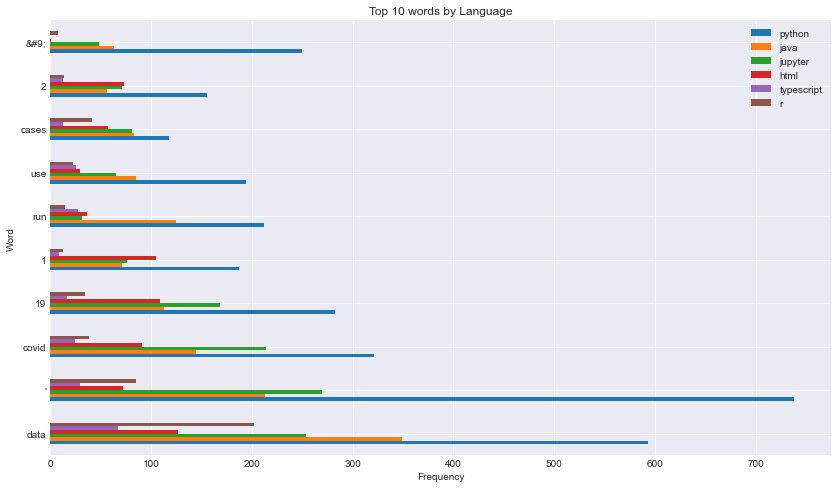

In [18]:
#using 'all' languages
#visualize top 10
word_counts.sort_values('all', ascending=False).head(10)[['python', 'java', 'jupyter', 'html', 'typescript', 'r']].plot.barh()

plt.title('Top 10 words by Language')
plt.xlabel('Frequency')
plt.ylabel('Word')

In [19]:
#visual proportions
#axis=1 in .apply means row by row
word_counts.sort_values(by='all', ascending=False).head(10).apply(lambda row: row/ row['all'],axis=1)

,python,java,jupyter,html,typescript,r,all
data,0.372487,0.219221,0.159548,0.079774,0.042085,0.126884,1.0
',0.524148,0.151278,0.191761,0.051136,0.021307,0.060369,1.0
covid,0.384431,0.173653,0.256287,0.108982,0.029940,0.046707,1.0
19,0.389807,0.155647,0.232782,0.150138,0.023416,0.048209,1.0
1,0.405640,0.154013,0.164859,0.227766,0.019523,0.028200,1.0
run,0.472160,0.278396,0.071269,0.082405,0.062361,0.033408,1.0
use,0.458629,0.200946,0.153664,0.070922,0.061466,0.054374,1.0
cases,0.299492,0.210660,0.205584,0.144670,0.032995,0.106599,1.0
2,0.407311,0.146214,0.185379,0.190601,0.033943,0.036554,1.0
&#9;,0.673854,0.169811,0.132075,0.002695,0.000000,0.021563,1.0


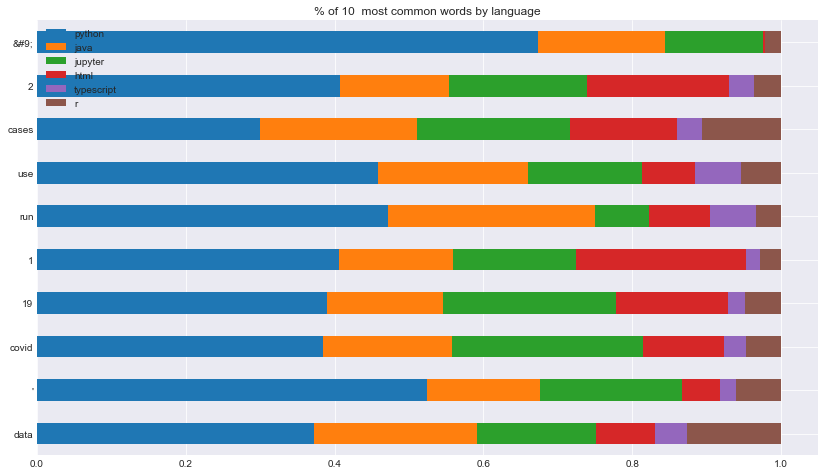

In [20]:
#visualize all languages as percent of 'all'
(word_counts.sort_values(by='all', ascending=False)
 .head(10)
 .apply(lambda row: row/ row['all'],axis=1)
 .drop(columns='all')
 .plot.barh(stacked=True))
plt.title('% of 10  most common words by language')
None

<hr style="border:1px solid black"> </hr>

# n-grams

### Python

In [21]:
#see most common bigrams in python languages
pd.Series(nltk.bigrams(python_words.split())).value_counts()

(covid, 19)                  236
(', ')                        99
(&#9;, &#9;)                  81
(default, null)               66
(pip, install)                64
                            ... 
(infection, transmission)      1
(module, package)              1
(files, requires)              1
(possible, without)            1
(repo, sh)                     1
Length: 31049, dtype: int64

### JavaScript

In [22]:
#see most common bigrams in JavaScript language
pd.Series(nltk.bigrams(java_words.split())).value_counts()

(covid, 19)             108
(npm, install)           26
(npm, run)               23
(&#9;, &#9;)             22
(county, timeseries)     20
                       ... 
(record, upload)          1
(click, mitigation)       1
(test, deploying)         1
(porting, extension)      1
(might, gap)              1
Length: 14844, dtype: int64

### Jupyter Notebook

In [23]:
#see most common bigrams in JupyterNotebook language
pd.Series(nltk.bigrams(jupyter_words.split())).value_counts()

(covid, 19)               157
(', 00)                    38
(confirmed, cases)         27
(south, africa)            26
(pip, install)             20
                         ... 
(becomes, challenging)      1
(van, heerden)              1
(device, takes)             1
(reports, confirmed)        1
(far, feel)                 1
Length: 11910, dtype: int64

### HTML

In [24]:
#see most common bigrams in HTML language
pd.Series(nltk.bigrams(html_words.split())).value_counts()

(covid, 19)           87
(confirmed, cases)    17
(plotscovid, 19)      13
(19, florida)         13
(us, states)          12
                      ..
(14, new)              1
(reading, writing)     1
(much, better)         1
(started, 1)           1
(often, case)          1
Length: 7485, dtype: int64

### TypeScript

In [25]:
#see most common bigrams in TypeScript language
pd.Series(nltk.bigrams(type_words.split())).value_counts()

(covid, 19)             16
(mm, dd)                15
(dateyyyy, mm)          12
(http, get)             11
(qr, code)               9
                        ..
(tests, anzahl)          1
(nametag, docker)        1
(run, passkit)           1
(expect, javascript)     1
(form, summary)          1
Length: 3811, dtype: int64

### R

In [26]:
#see most common bigrams in R language
pd.Series(nltk.bigrams(r_words.split())).value_counts()

(covid, 19)             34
(2020, 04)              18
(confirmed, cases)      16
(cases, country)        11
(data, source)          10
                        ..
(codes, using)           1
(contributions, new)     1
(list, region)           1
(backlog, 10k)           1
(reported, hence)        1
Length: 4430, dtype: int64

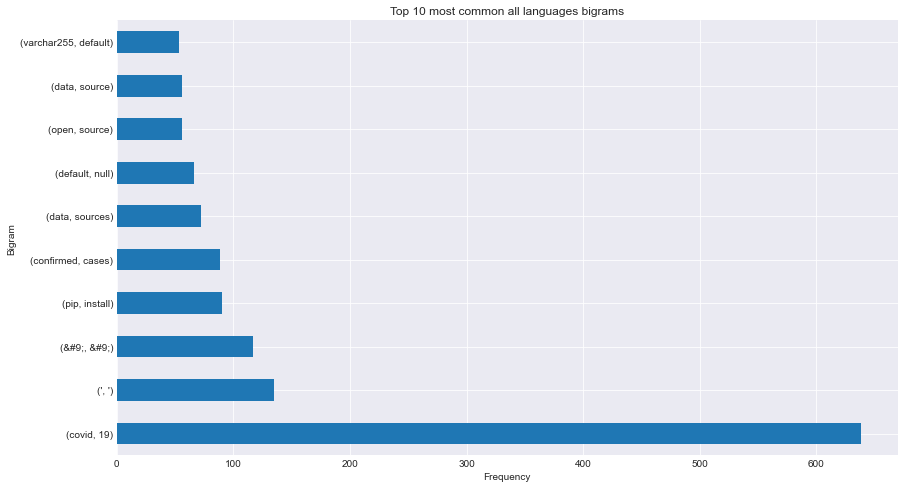

In [27]:
#visualize top ten for all languages
pd.Series(nltk.bigrams(all_words.split())).value_counts().head(10).plot.barh()
plt.title('Top 10 most common all languages bigrams')
plt.ylabel('Bigram')
plt.xlabel('Frequency')
None

<hr style="border:1px solid black"> </hr>

# Word Clouds

### Python

(-0.5, 799.5, 599.5, -0.5)

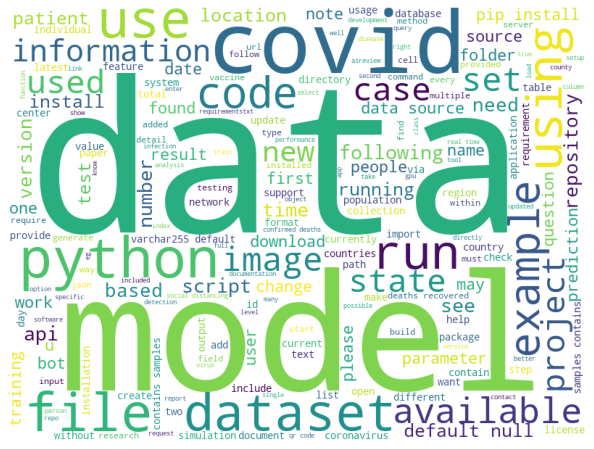

In [28]:
img = WordCloud(background_color='white', width=800, height=600).generate(python_words)
plt.imshow(img)
plt.axis('off')

### JavaScript

(-0.5, 799.5, 599.5, -0.5)

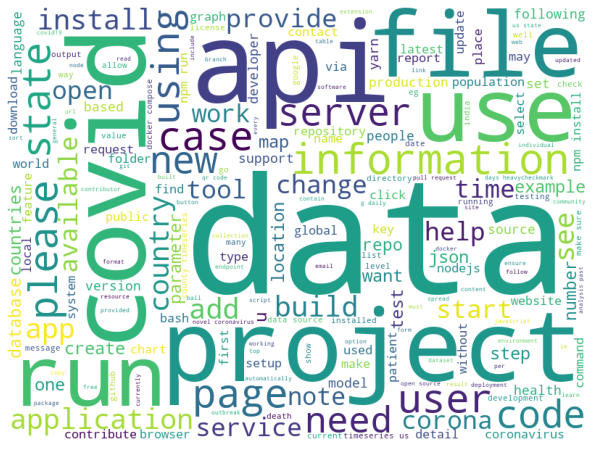

In [29]:
img = WordCloud(background_color='white', width=800, height=600).generate(java_words)
plt.imshow(img)
plt.axis('off')

### Jupyter Notebook

(-0.5, 799.5, 599.5, -0.5)

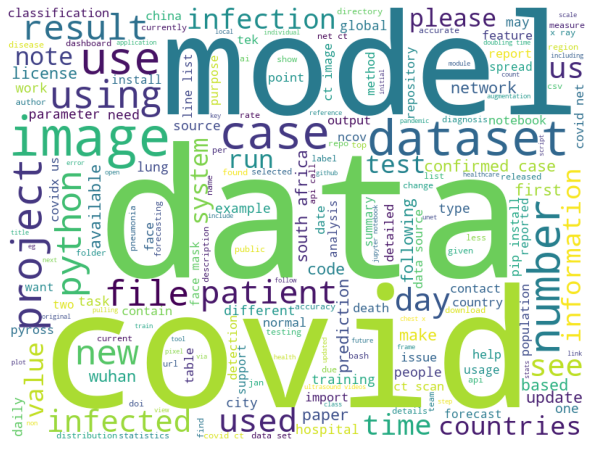

In [30]:
img = WordCloud(background_color='white', width=800, height=600).generate(jupyter_words)
plt.imshow(img)
plt.axis('off')

### HTML

(-0.5, 799.5, 599.5, -0.5)

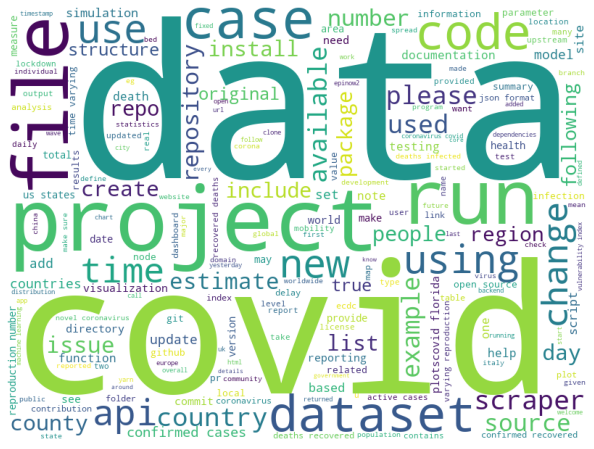

In [31]:
img = WordCloud(background_color='white', width=800, height=600).generate(html_words)
plt.imshow(img)
plt.axis('off')

### TypeScript

(-0.5, 799.5, 599.5, -0.5)

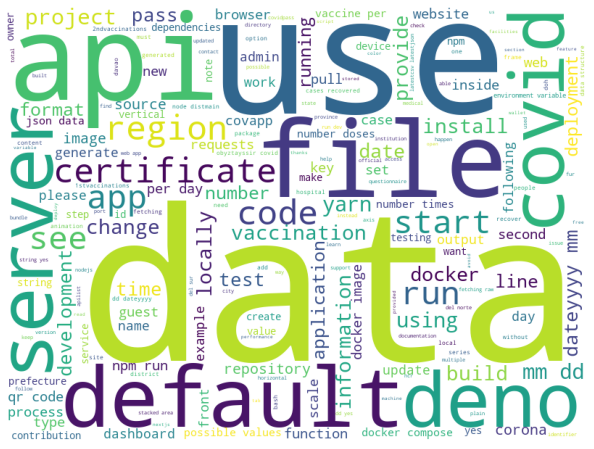

In [32]:
img = WordCloud(background_color='white', width=800, height=600).generate(type_words)
plt.imshow(img)
plt.axis('off')

### R

(-0.5, 799.5, 599.5, -0.5)

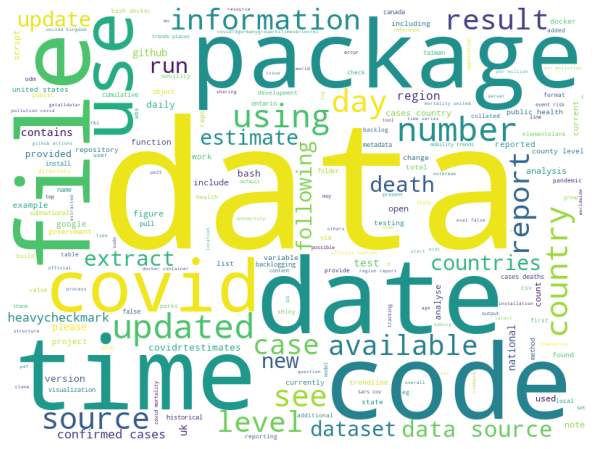

In [33]:
img = WordCloud(background_color='white', width=800, height=600).generate(r_words)
plt.imshow(img)
plt.axis('off')

<hr style="border:2px solid black"> </hr>

# Model

In [34]:
df.head()

,repository,original_readme,cleaned_readme,lemmatized_readme,original_char_length,cleaned_char_length,pct_char_removed,natural_language,programming_language
0,ieee8023/covid-chestxray-dataset,\n#### 🛑 Note: please do not claim diagnostic ...,note please claim diagnostic performance model...,note please claim diagnostic performance model...,10610,4170,39,en,Jupyter Notebook
1,geohot/corona,# Reverse engineering the coronavirus (SARS-Co...,reverse engineering coronavirus sars cov 2 sta...,reverse engineering coronavirus sars cov 2 sta...,13101,3883,29,en,Python
2,ahmadawais/corona-cli,"<h4 align=""center"">\n <a href=""https://gith...",track coronavirus disease covid 19 novel coron...,track coronavirus disease covid 19 novel coron...,15371,4855,31,en,JavaScript
3,ExpDev07/coronavirus-tracker-api,"<h1 align=""center"">\n Coronavirus Tracker A...",coronavirus tracker api provides date data cor...,coronavirus tracker api provides date data cor...,26918,7035,26,en,Python
4,neherlab/covid19_scenarios,"<h1 id=""covid19_scenarios"" align=""center"">\n ...",covid 19 scenarios models covid 19 outbreak tr...,covid 19 scenario model covid 19 outbreak traj...,54727,6456,11,en,JavaScript


In [35]:
#term frequency
cv = CountVectorizer()
#identify X
X = cv.fit_transform(df.cleaned_readme)
#identify target (language)
y = df.programming_language

In [36]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

In [37]:
#find value counts to find baseline language
y_train.value_counts()

Python              72
JavaScript          35
Jupyter Notebook    26
HTML                12
R                   10
TypeScript           9
Name: programming_language, dtype: int64

In [38]:
df.head()

,repository,original_readme,cleaned_readme,lemmatized_readme,original_char_length,cleaned_char_length,pct_char_removed,natural_language,programming_language
0,ieee8023/covid-chestxray-dataset,\n#### 🛑 Note: please do not claim diagnostic ...,note please claim diagnostic performance model...,note please claim diagnostic performance model...,10610,4170,39,en,Jupyter Notebook
1,geohot/corona,# Reverse engineering the coronavirus (SARS-Co...,reverse engineering coronavirus sars cov 2 sta...,reverse engineering coronavirus sars cov 2 sta...,13101,3883,29,en,Python
2,ahmadawais/corona-cli,"<h4 align=""center"">\n <a href=""https://gith...",track coronavirus disease covid 19 novel coron...,track coronavirus disease covid 19 novel coron...,15371,4855,31,en,JavaScript
3,ExpDev07/coronavirus-tracker-api,"<h1 align=""center"">\n Coronavirus Tracker A...",coronavirus tracker api provides date data cor...,coronavirus tracker api provides date data cor...,26918,7035,26,en,Python
4,neherlab/covid19_scenarios,"<h1 id=""covid19_scenarios"" align=""center"">\n ...",covid 19 scenarios models covid 19 outbreak tr...,covid 19 scenario model covid 19 outbreak traj...,54727,6456,11,en,JavaScript


In [39]:
baseline_accuracy = (y_train == 'Python').mean()
print(f'Baseline accuracy is: {baseline_accuracy:.2%}')

Baseline accuracy is: 43.90%


## Decision Tree Model

In [40]:
#create model - decision tree classifier
tree = DecisionTreeClassifier(max_depth=5, random_state=123)
#fit
tree.fit(X_train, y_train)

#get scores 
print(f'training score for Decision Tree(max_depth =5): {tree.score(X_train, y_train):.2%}')
print(f'test score for Decision Tree(max_depth =5): {tree.score(X_test, y_test):.2%}')

training score for Decision Tree(max_depth =5): 77.44%
test score for Decision Tree(max_depth =5): 48.78%


In [41]:
#create model - decision tree classifier
tree2 = DecisionTreeClassifier(max_depth=3, random_state=123)

#fit the model
tree2.fit(X_train, y_train)

#get scores 
print(f'training score for Decision Tree(max_depth =3): {tree2.score(X_train, y_train):.2%}')
print(f'test score for Decision Tree(max_depth =3): {tree2.score(X_test, y_test):.2%}')

training score for Decision Tree(max_depth =3): 63.41%
test score for Decision Tree(max_depth =3): 51.22%


In [42]:
#create model - decision tree classifier
tree3 = DecisionTreeClassifier(max_depth=10, random_state=123)

#fit the model
tree3.fit(X_train, y_train)

#get scores 
print(f'training score for Decision Tree(max_depth =10): {tree3.score(X_train, y_train):.2%}')
print(f'test score for Decision Tree(max_depth =10): {tree3.score(X_test, y_test):.2%}')

training score for Decision Tree(max_depth =10): 96.34%
test score for Decision Tree(max_depth =10): 48.78%


## Logistic Regression

In [43]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.cleaned_readme)
y = df.programming_language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [44]:
from sklearn.metrics import classification_report, accuracy_score

In [46]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 70.12%
Accuracy: 48.78%
---
Confusion Matrix
actual            HTML  JavaScript  Jupyter Notebook  Python   R  TypeScript
predicted                                                                   
JavaScript           0          34                 0       0   0           1
Jupyter Notebook     0           0                 9       0   0           0
Python              12           1                17      72  10           8
---
                  precision    recall  f1-score   support

            HTML       0.00      0.00      0.00        12
      JavaScript       0.97      0.97      0.97        35
Jupyter Notebook       1.00      0.35      0.51        26
          Python       0.60      1.00      0.75        72
               R       0.00      0.00      0.00        10
      TypeScript       0.00      0.00      0.00         9

        accuracy                           0.70       164
       macro avg       0.43      0.39      0.37       164
    weighted avg       0.63     

/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
